# STAYSL Walk-through NIF
This example walks through the 
Passive 18x snout on TANDM 90-348 NIF Foil Activation Experiment performed by
Energetic Neutron Platform Working Group and NIF Radiochemistry Group

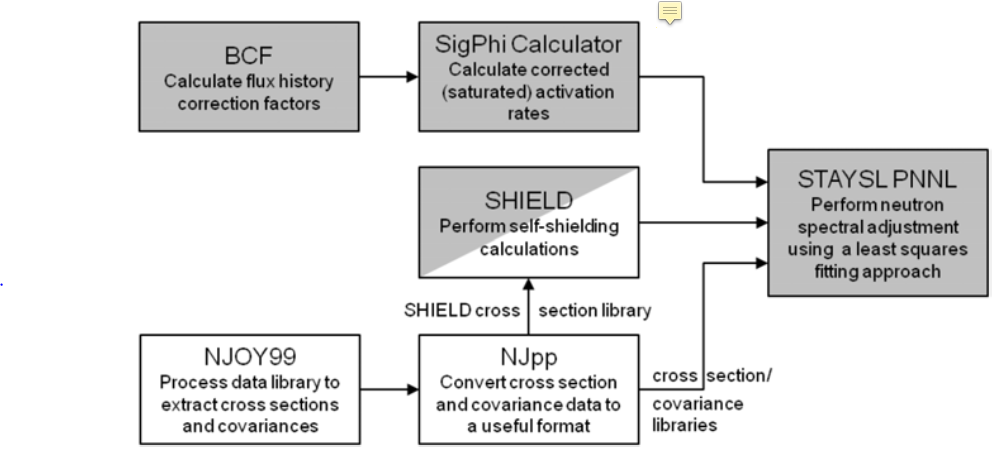
- This is from EPJWeb of Conferences 106, 07001 (2016) Least-Squares Neutron Spectral Adjustment with STAYSL PNNL L.R. Greenwooda and C.D. Johnson

# BCF - Beam Correction Factor
BCF corrects for irradiation history. The calculations performed correct for production and decay during the irradiation. At constant power or flux, this is a simple process 

$A_{0}=A_{\infty}*(1-exp(-\lambda*t))$

BCF normalizes the irradiation history to the time-weighted average reactor power or beam current. A correction factor is produced based on the irradiation hisotry for each isotope of interest. 

For the NIF, this module is not needed, BCF is not needef for a short irradiation time

## SHIELD
The SHIELD code calculates energy-dependent neutron self-shielding cross section correction factors that are used, prior to neutron spectral adjustment, to shield the neutron activation cross sections used by the STAYSL PNNL code. 

SHIELD was performed on ["shldinputNIF.dat"](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SHIELD/shldinputNIF.dat). 

After a painstaking process of trial and error. It was determined that my executable of the SHIELD.exe can only be ran if: 
- Run command prompt as an administrator
- Use runExample batch file with filename replaced with desired input

I am unsure of why it requires this, I am guessing it is a permissions issue that I cannot work out. 

SHIELD is only necessary/valid on non-threshold reactions (n,gamma). SHIELD is dependent on the thickness of the material, so it must be re-ran if different foils/wires are used. 

An output file is created in the same directory shldinput.out

All foils are 1 mm (39.3701 mils) except for the Au foils, which are 0.1 mm

The output is renamed sshldlib.dat


## SigPhi Calculator

The [SigPhi Calculator](https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/Unfold/SIGPHI/SigPhi_Calculator_NIF.xlsm) was filled in with data from the [foil and activity information] (https://github.com/nickquartemont/NENG612/tree/master/NIF_Unfold/ActivationData.xlsx)


The purpose of the SigPhi Calculator software is to calculate corrected saturated neutron activation rates from measured activities. These reaction rates, the so-called sig-phi values, represent the product of the spectral-averaged neutron activation cross section and the total neutron flux

The NIF is a very prompt output (~200 ps). There will be some downscatter which may slow a portion down. However, for the purposes of the irradiation, the irradiation time is taken as 1 second, and the reaction rates are taken as per second. This will not impact the results because the half-lives of the measured products are orders of magnitude different from this result. 

The export to excel did not work. Instead, the input was built-up using the calculated gamma shielding and At/At-s from the foil and activity information sheet

I couldn't get the SigPhi Calculator to work for me. I redownloaded everything and it gives me: 
￿￿￿￿￿￿￿￿￿￿ when I try to export to a STAYSL script. After this is completed. I plan on sending in the bugs to PNNL

The sig-phi is calculated by dividing the number of nuclei created at t0 by the total number of atoms present in the foil. This is the relative production. 

The self-shielding factor for gammas is divided by this to correct for gamma self-shielding


# STAYSL

The STAYSL input deck was made with the SIG_PHI calculator and foil/activation data. 

The default values (From examples distributed with STAYSL) for Gaussian formalism were used. 

An iterative solution was performed on the input data and sets the uncertainty below 13 MeV to 100%. This was chosen because the model did not predict the down-scattering well. The baseline guess spectrum was initially developed using an Appelbe source split with a 14.03 MeV neutron peak at 10.75 keV temperature (See foil/activation Excel doc). 

After the initial results from the Appelbe source, it was clear that there was a large downscattering term. 

An estimation of the foil (13-14 MeV and 14-15 MeV) flux was done in the activation spreadsheet. The (n,2n) reactions were almost exactly what the guess predicted; however, the (n,g) and (n,n') reactions were underpredicting by over an order of magnitude. This suggests that there is a decent amount of scattering to lower energy groups. 

The guess spectrum was created with MCNP input file wrf80.i. Some modifications were made to set the tally results to stop at the 15th STAYSL energy bin. 

The low energy region was modified for each output guess spectrum. There is not a lot of statistics in the low energy bins. The low energy region above 4.25 eV was approximated as by the surrounding tally bins. 

The guess spectrum is not a perfect replication of the exact experiment, so modifications were made to the uncertainties. 
For the pinhole, the uncertainty was: 
- (13-16 MeV): 10%
- (.36 MeV - 13 MeV): 20%
- 4.25 eV- 0.36 MeV): 100%

The uncertainty from the model was much smaller from the MCNP run; however, this allows for the problem to not be entirely constrained by the initial guess for the iterations, especially in lower energy regions where less is known. A similar approach was taken for basket and kinematic base

In [1]:
import sys
import os
sys.path.insert(0,os.path.abspath('C:/Users/nickq/Documents/AFIT_Masters/PyScripts/src'))
import pandas as pd
from DataAnalysis.DataManipulation import bin_integration, bin_differentiation
from DataAnalysis.Histograms import Histogram
import matplotlib
from Unfolding.STAYSLmodified import IterativeSTAYSL

%matplotlib inline
import scipy.stats as stats
#http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html

STAYSL is ran by executing the executable from the command line. The first iteration of STAYSL is performed manually. The output from that is placed into folder Iteration1. 



# Pinhole Results

The plots have been moved to NENG 612/Unfold/plots.py. Jupyter notebook keeps crashing. Spyder is more reliable

# Pin Iterative Solution: 1
  - The uncertainty is not updated until $\chi^2$ converged.

In [18]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.0001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.0001
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 772.78898, Std Norm = 6.31823919379
Chi^2 = 325.37532
Chi^2 = 188.69551
Chi^2 = 61.05474
Chi^2 = 21.22135
Chi^2 = 19.55688
Chi^2 = 19.52372
Chi^2 = 19.50775
Chi^2 = 19.49146
Chi^2 = 19.47536
Chi^2 = 19.45909
Chi^2 = 19.44294
Chi^2 = 19.42718
Chi^2 = 19.41116
Chi^2 = 19.39516
Chi^2 = 19.37915
Chi^2 = 19.36318
Chi^2 = 19.34722
Chi^2 = 19.33126
Chi^2 = 19.31494
Chi^2 = 19.29899
Chi^2 = 19.28267
Chi^2 = 19.26671
Chi^2 = 19.25075
Chi^2 = 19.23443
Chi^2 = 19.21846
Chi^2 = 19.20213
Chi^2 = 19.18616
Chi^2 = 19.17018
Chi^2 = 19.15383
Chi^2 = 19.13786
Chi^2 = 19.1215
Chi^2 = 19.10551
Chi^2 = 19.08952
Chi^2 = 

Chi^2 = 12.74549
Chi^2 = 12.73425
Chi^2 = 12.72303
Chi^2 = 12.71197
Chi^2 = 12.70086
Chi^2 = 12.68967
Chi^2 = 12.67851
Chi^2 = 12.66747
Chi^2 = 12.65634
Chi^2 = 12.64524
Chi^2 = 12.63426
Chi^2 = 12.62322
Chi^2 = 12.61226
Chi^2 = 12.60124
Chi^2 = 12.59032
Chi^2 = 12.57938
Chi^2 = 12.56847
Chi^2 = 12.55747
Chi^2 = 12.54659
Chi^2 = 12.53581
Chi^2 = 12.52488
Chi^2 = 12.51411
Chi^2 = 12.50335
Chi^2 = 12.49261
Chi^2 = 12.48192
Chi^2 = 12.47124
Chi^2 = 12.46047
Chi^2 = 12.44978
Chi^2 = 12.43909
Chi^2 = 12.42844
Chi^2 = 12.41779
Chi^2 = 12.40715
Chi^2 = 12.39658
Chi^2 = 12.38594
Chi^2 = 12.37535
Chi^2 = 12.36478
Chi^2 = 12.35419
Chi^2 = 12.34364
Chi^2 = 12.33312
Chi^2 = 12.32258
Chi^2 = 12.31218
Chi^2 = 12.30175
Chi^2 = 12.29129
Chi^2 = 12.28083
Chi^2 = 12.27051
Chi^2 = 12.26012
Chi^2 = 12.24971
Chi^2 = 12.23947
Chi^2 = 12.2291
Chi^2 = 12.21889
Chi^2 = 12.2086
Chi^2 = 12.19839
Chi^2 = 12.18812
Chi^2 = 12.17795
Chi^2 = 12.16769
Chi^2 = 12.15755
Chi^2 = 12.14747
Chi^2 = 12.13726
Chi^2 = 12.12715

Chi^2 = 9.02526
Chi^2 = 9.02043
Chi^2 = 9.01561
Chi^2 = 9.01077
Chi^2 = 9.0059
Chi^2 = 9.00111
Chi^2 = 8.99629
Chi^2 = 8.9915
Chi^2 = 8.98666
Chi^2 = 8.98192
Chi^2 = 8.97712
Chi^2 = 8.9724
Chi^2 = 8.9676
Chi^2 = 8.96289
Chi^2 = 8.9581
Chi^2 = 8.95339
Chi^2 = 8.94861
Chi^2 = 8.9439
Chi^2 = 8.93913
Chi^2 = 8.93443
Chi^2 = 8.92973
Chi^2 = 8.92502
Chi^2 = 8.92033
Chi^2 = 8.91563
Chi^2 = 8.91094
Chi^2 = 8.90631
Chi^2 = 8.90161
Chi^2 = 8.89694
Chi^2 = 8.89231
Chi^2 = 8.88763
Chi^2 = 8.88301
Chi^2 = 8.87841
Chi^2 = 8.87373
Chi^2 = 8.86913
Chi^2 = 8.86453
Chi^2 = 8.85993
Chi^2 = 8.85532
Chi^2 = 8.85073
Chi^2 = 8.84611
Chi^2 = 8.84158
Chi^2 = 8.83695
Chi^2 = 8.83235
Chi^2 = 8.82778
Chi^2 = 8.82323
Chi^2 = 8.81869
Chi^2 = 8.81411
Chi^2 = 8.80953
Chi^2 = 8.80495
Chi^2 = 8.80045
Chi^2 = 8.79591
Chi^2 = 8.79138
Chi^2 = 8.78687
Chi^2 = 8.78232
Chi^2 = 8.77781
Chi^2 = 8.77333
Chi^2 = 8.76882
Chi^2 = 8.76432
Chi^2 = 8.7599
Chi^2 = 8.75544
Chi^2 = 8.751
Chi^2 = 8.74659
Chi^2 = 8.74215
Chi^2 = 8.73771
C

Chi^2 = 7.20995
Chi^2 = 7.20741
Chi^2 = 7.2048
Chi^2 = 7.20223
Chi^2 = 7.19966
Chi^2 = 7.19713
Chi^2 = 7.19456
Chi^2 = 7.19198
Chi^2 = 7.18942
Chi^2 = 7.1869
Chi^2 = 7.18433
Chi^2 = 7.18178
Chi^2 = 7.17923
Chi^2 = 7.17671
Chi^2 = 7.17419
Chi^2 = 7.17164
Chi^2 = 7.16913
Chi^2 = 7.16657
Chi^2 = 7.16403
Chi^2 = 7.16152
Chi^2 = 7.15901
Chi^2 = 7.15646
Chi^2 = 7.15393
Chi^2 = 7.15142
Chi^2 = 7.14893
Chi^2 = 7.1464
Chi^2 = 7.1439
Chi^2 = 7.14141
Chi^2 = 7.13892
Chi^2 = 7.13642
Chi^2 = 7.13394
Chi^2 = 7.13145
Chi^2 = 7.12896
Chi^2 = 7.12648
Chi^2 = 7.124
Chi^2 = 7.12152
Chi^2 = 7.11905
Chi^2 = 7.11656
Chi^2 = 7.11409
Chi^2 = 7.11162
Chi^2 = 7.10914
Chi^2 = 7.10667
Chi^2 = 7.1042
Chi^2 = 7.10172
Chi^2 = 7.09925
Chi^2 = 7.09679
Chi^2 = 7.0943
Chi^2 = 7.09183
Chi^2 = 7.0894
Chi^2 = 7.08694
Chi^2 = 7.08448
Chi^2 = 7.08204
Chi^2 = 7.07959
Chi^2 = 7.07716
Chi^2 = 7.0747
Chi^2 = 7.07225
Chi^2 = 7.06981
Chi^2 = 7.06736
Chi^2 = 7.06493
Chi^2 = 7.06249
Chi^2 = 7.06006
Chi^2 = 7.05767
Chi^2 = 7.05524
Ch

Chi^2 = 6.14291
Chi^2 = 6.14123
Chi^2 = 6.13955
Chi^2 = 6.13787
Chi^2 = 6.13619
Chi^2 = 6.13452
Chi^2 = 6.13285
Chi^2 = 6.13117
Chi^2 = 6.12949
Chi^2 = 6.1278
Chi^2 = 6.12613
Chi^2 = 6.12446
Chi^2 = 6.1228
Chi^2 = 6.12113
Chi^2 = 6.11947
Chi^2 = 6.11781
Chi^2 = 6.11615
Chi^2 = 6.11449
Chi^2 = 6.11282
Chi^2 = 6.11116
Chi^2 = 6.1095
Chi^2 = 6.10784
Chi^2 = 6.10618
Chi^2 = 6.10452
Chi^2 = 6.10287
Chi^2 = 6.10121
Chi^2 = 6.09956
Chi^2 = 6.0979
Chi^2 = 6.09625
Chi^2 = 6.09459
Chi^2 = 6.09294
Chi^2 = 6.09129
Chi^2 = 6.08964
Chi^2 = 6.08798
Chi^2 = 6.08633
Chi^2 = 6.08468
Chi^2 = 6.08303
Chi^2 = 6.08138
Chi^2 = 6.07973
Chi^2 = 6.07808
Chi^2 = 6.07645
Chi^2 = 6.0748
Chi^2 = 6.07319
Chi^2 = 6.07154
Chi^2 = 6.06993
Chi^2 = 6.06834
Chi^2 = 6.06669
Chi^2 = 6.06508
Chi^2 = 6.06344
Chi^2 = 6.06183
Chi^2 = 6.06023
Chi^2 = 6.05859
Chi^2 = 6.05699
Chi^2 = 6.05536
Chi^2 = 6.05376
Chi^2 = 6.05218
Chi^2 = 6.05055
Chi^2 = 6.04895
Chi^2 = 6.0473
Chi^2 = 6.0457
Chi^2 = 6.04409
Chi^2 = 6.04246
Chi^2 = 6.04086

Chi^2 = 5.40746
Chi^2 = 5.40624
Chi^2 = 5.40504
Chi^2 = 5.40384
Chi^2 = 5.40264
Chi^2 = 5.40142
Chi^2 = 5.4002
Chi^2 = 5.39904
Chi^2 = 5.39784
Chi^2 = 5.39662
Chi^2 = 5.3954
Chi^2 = 5.39424
Chi^2 = 5.39305
Chi^2 = 5.39183
Chi^2 = 5.39061
Chi^2 = 5.38945
Chi^2 = 5.38825
Chi^2 = 5.38706
Chi^2 = 5.38584
Chi^2 = 5.38462
Chi^2 = 5.38346
Chi^2 = 5.38227
Chi^2 = 5.38105
Chi^2 = 5.37983
Chi^2 = 5.37867
Chi^2 = 5.37748
Chi^2 = 5.37627
Chi^2 = 5.37505
Chi^2 = 5.37389
Chi^2 = 5.37274
Chi^2 = 5.37152
Chi^2 = 5.37033
Chi^2 = 5.36917
Chi^2 = 5.36799
Chi^2 = 5.36678
Chi^2 = 5.36557
Chi^2 = 5.36442
Chi^2 = 5.36324
Chi^2 = 5.36203
Chi^2 = 5.36082
Chi^2 = 5.35967
Chi^2 = 5.35852
Chi^2 = 5.35732
Chi^2 = 5.35613
Chi^2 = 5.35499
Chi^2 = 5.35378
Chi^2 = 5.3526
Chi^2 = 5.35145
Chi^2 = 5.3503
Chi^2 = 5.3491
Chi^2 = 5.34792
Chi^2 = 5.34677
Chi^2 = 5.34558
Chi^2 = 5.3444
Chi^2 = 5.34325
Chi^2 = 5.34211
Chi^2 = 5.3409
Chi^2 = 5.33972
Chi^2 = 5.33858
Chi^2 = 5.33738
Chi^2 = 5.3362
Chi^2 = 5.33506
Chi^2 = 5.33392


Chi^2 = 4.85425
Chi^2 = 4.85332
Chi^2 = 4.85235
Chi^2 = 4.85139
Chi^2 = 4.85043
Chi^2 = 4.84947
Chi^2 = 4.84851
Chi^2 = 4.84757
Chi^2 = 4.84661
Chi^2 = 4.84564
Chi^2 = 4.84467
Chi^2 = 4.84371
Chi^2 = 4.84275
Chi^2 = 4.84179
Chi^2 = 4.84083
Chi^2 = 4.83988
Chi^2 = 4.83892
Chi^2 = 4.83796
Chi^2 = 4.83704
Chi^2 = 4.83608
Chi^2 = 4.83512
Chi^2 = 4.83423
Chi^2 = 4.83327
Chi^2 = 4.83231
Chi^2 = 4.83135
Chi^2 = 4.83039
Chi^2 = 4.82943
Chi^2 = 4.82854
Chi^2 = 4.82758
Chi^2 = 4.82662
Chi^2 = 4.8257
Chi^2 = 4.82474
Chi^2 = 4.82379
Chi^2 = 4.82286
Chi^2 = 4.8219
Chi^2 = 4.82095
Chi^2 = 4.82005
Chi^2 = 4.8191
Chi^2 = 4.81814
Chi^2 = 4.81725
Chi^2 = 4.81629
Chi^2 = 4.81534
Chi^2 = 4.81441
Chi^2 = 4.81346
Chi^2 = 4.81251
Chi^2 = 4.81162
Chi^2 = 4.8107
Chi^2 = 4.80974
Chi^2 = 4.80885
Chi^2 = 4.80792
Chi^2 = 4.80697
Chi^2 = 4.80608
Chi^2 = 4.8052
Chi^2 = 4.80425
Chi^2 = 4.8033
Chi^2 = 4.80241
Chi^2 = 4.80148
Chi^2 = 4.80053
Chi^2 = 4.79964
Chi^2 = 4.79876
Chi^2 = 4.7978
Chi^2 = 4.79685
Chi^2 = 4.79596

Chi^2 = 4.4167
Chi^2 = 4.41592
Chi^2 = 4.41514
Chi^2 = 4.41436
Chi^2 = 4.41359
Chi^2 = 4.41281
Chi^2 = 4.41204
Chi^2 = 4.41127
Chi^2 = 4.41049
Chi^2 = 4.40972
Chi^2 = 4.40894
Chi^2 = 4.40817
Chi^2 = 4.40739
Chi^2 = 4.40662
Chi^2 = 4.40585
Chi^2 = 4.40507
Chi^2 = 4.4043
Chi^2 = 4.40352
Chi^2 = 4.40275
Chi^2 = 4.40198
Chi^2 = 4.4012
Chi^2 = 4.40043
Chi^2 = 4.39966
Chi^2 = 4.39888
Chi^2 = 4.39812
Chi^2 = 4.39736
Chi^2 = 4.39658
Chi^2 = 4.3958
Chi^2 = 4.39503
Chi^2 = 4.39426
Chi^2 = 4.39349
Chi^2 = 4.39272
Chi^2 = 4.39194
Chi^2 = 4.39117
Chi^2 = 4.3904
Chi^2 = 4.38963
Chi^2 = 4.38886
Chi^2 = 4.3881
Chi^2 = 4.38733
Chi^2 = 4.38655
Chi^2 = 4.38579
Chi^2 = 4.38502
Chi^2 = 4.38425
Chi^2 = 4.38348
Chi^2 = 4.38272
Chi^2 = 4.38194
Chi^2 = 4.38119
Chi^2 = 4.38042
Chi^2 = 4.37966
Chi^2 = 4.3789
Chi^2 = 4.37814
Chi^2 = 4.37737
Chi^2 = 4.37661
Chi^2 = 4.37585
Chi^2 = 4.37509
Chi^2 = 4.37432
Chi^2 = 4.37356
Chi^2 = 4.3728
Chi^2 = 4.37204
Chi^2 = 4.37128
Chi^2 = 4.37051
Chi^2 = 4.36976
Chi^2 = 4.369
Ch

Chi^2 = 4.0521
Chi^2 = 4.05145
Chi^2 = 4.0508
Chi^2 = 4.05016
Chi^2 = 4.04952
Chi^2 = 4.04887
Chi^2 = 4.04823
Chi^2 = 4.04759
Chi^2 = 4.04698
Chi^2 = 4.04633
Chi^2 = 4.04569
Chi^2 = 4.04505
Chi^2 = 4.0444
Chi^2 = 4.04377
Chi^2 = 4.04312
Chi^2 = 4.04252
Chi^2 = 4.04187
Chi^2 = 4.04123
Chi^2 = 4.04059
Chi^2 = 4.03994
Chi^2 = 4.0393
Chi^2 = 4.03866
Chi^2 = 4.03806
Chi^2 = 4.03741
Chi^2 = 4.03677
Chi^2 = 4.03615
Chi^2 = 4.03554
Chi^2 = 4.0349
Chi^2 = 4.03426
Chi^2 = 4.03365
Chi^2 = 4.03301
Chi^2 = 4.03239
Chi^2 = 4.03178
Chi^2 = 4.03114
Chi^2 = 4.03053
Chi^2 = 4.02992
Chi^2 = 4.02928
Chi^2 = 4.02864
Chi^2 = 4.02803
Chi^2 = 4.02739
Chi^2 = 4.02679
Chi^2 = 4.02618
Chi^2 = 4.02554
Chi^2 = 4.0249
Chi^2 = 4.02429
Chi^2 = 4.02365
Chi^2 = 4.02303
Chi^2 = 4.02242
Chi^2 = 4.02178
Chi^2 = 4.02114
Chi^2 = 4.02053
Chi^2 = 4.0199
Chi^2 = 4.0193
Chi^2 = 4.01869
Chi^2 = 4.01805
Chi^2 = 4.01742
Chi^2 = 4.01681
Chi^2 = 4.01617
Chi^2 = 4.01555
Chi^2 = 4.01494
Chi^2 = 4.0143
Chi^2 = 4.01368
Chi^2 = 4.01307
C

Chi^2 = 3.74613
Chi^2 = 3.74559
Chi^2 = 3.74504
Chi^2 = 3.7445
Chi^2 = 3.74396
Chi^2 = 3.74342
Chi^2 = 3.74288
Chi^2 = 3.74232
Chi^2 = 3.74178
Chi^2 = 3.74123
Chi^2 = 3.74069
Chi^2 = 3.74013
Chi^2 = 3.7396
Chi^2 = 3.73904
Chi^2 = 3.73851
Chi^2 = 3.73795
Chi^2 = 3.73742
Chi^2 = 3.73688
Chi^2 = 3.73634
Chi^2 = 3.7358
Chi^2 = 3.73525
Chi^2 = 3.73471
Chi^2 = 3.73415
Chi^2 = 3.73362
Chi^2 = 3.73306
Chi^2 = 3.73253
Chi^2 = 3.73198
Chi^2 = 3.73145
Chi^2 = 3.73089
Chi^2 = 3.73036
Chi^2 = 3.72982
Chi^2 = 3.72929
Chi^2 = 3.72875
Chi^2 = 3.72819
Chi^2 = 3.72766
Chi^2 = 3.72711
Chi^2 = 3.72657
Chi^2 = 3.72602
Chi^2 = 3.72549
Chi^2 = 3.72494
Chi^2 = 3.7244
Chi^2 = 3.72385
Chi^2 = 3.72332
Chi^2 = 3.72277
Chi^2 = 3.72224
Chi^2 = 3.72169
Chi^2 = 3.72116
Chi^2 = 3.72063
Chi^2 = 3.7201
Chi^2 = 3.71956
Chi^2 = 3.71903
Chi^2 = 3.7185
Chi^2 = 3.71795
Chi^2 = 3.71742
Chi^2 = 3.71687
Chi^2 = 3.71634
Chi^2 = 3.71579
Chi^2 = 3.71526
Chi^2 = 3.71471
Chi^2 = 3.71418
Chi^2 = 3.71364
Chi^2 = 3.71311
Chi^2 = 3.7125

Chi^2 = 3.48319
Chi^2 = 3.48271
Chi^2 = 3.48224
Chi^2 = 3.48176
Chi^2 = 3.48129
Chi^2 = 3.48081
Chi^2 = 3.48034
Chi^2 = 3.47986
Chi^2 = 3.47939
Chi^2 = 3.4789
Chi^2 = 3.47843
Chi^2 = 3.47796
Chi^2 = 3.47748
Chi^2 = 3.47701
Chi^2 = 3.47653
Chi^2 = 3.47606
Chi^2 = 3.47559
Chi^2 = 3.4751
Chi^2 = 3.47464
Chi^2 = 3.47414
Chi^2 = 3.47366
Chi^2 = 3.47319
Chi^2 = 3.47271
Chi^2 = 3.47224
Chi^2 = 3.47178
Chi^2 = 3.47129
Chi^2 = 3.47083
Chi^2 = 3.47035
Chi^2 = 3.46988
Chi^2 = 3.46941
Chi^2 = 3.46893
Chi^2 = 3.46846
Chi^2 = 3.46797
Chi^2 = 3.46749
Chi^2 = 3.46702
Chi^2 = 3.46654
Chi^2 = 3.46607
Chi^2 = 3.4656
Chi^2 = 3.46513
Chi^2 = 3.46466
Chi^2 = 3.46417
Chi^2 = 3.46369
Chi^2 = 3.46323
Chi^2 = 3.46275
Chi^2 = 3.46228
Chi^2 = 3.46181
Chi^2 = 3.46134
Chi^2 = 3.46087
Chi^2 = 3.46039
Chi^2 = 3.45992
Chi^2 = 3.45945
Chi^2 = 3.45898
Chi^2 = 3.45851
Chi^2 = 3.45804
Chi^2 = 3.45757
Chi^2 = 3.45711
Chi^2 = 3.45663
Chi^2 = 3.45615
Chi^2 = 3.45569
Chi^2 = 3.45521
Chi^2 = 3.45475
Chi^2 = 3.45428
Chi^2 = 3.4

Chi^2 = 3.2555
Chi^2 = 3.25509
Chi^2 = 3.25467
Chi^2 = 3.25427
Chi^2 = 3.25387
Chi^2 = 3.25346
Chi^2 = 3.25304
Chi^2 = 3.25264
Chi^2 = 3.25223
Chi^2 = 3.25181
Chi^2 = 3.25139
Chi^2 = 3.25099
Chi^2 = 3.2506
Chi^2 = 3.25019
Chi^2 = 3.24977
Chi^2 = 3.24937
Chi^2 = 3.24896
Chi^2 = 3.24855
Chi^2 = 3.24814
Chi^2 = 3.24773
Chi^2 = 3.24732
Chi^2 = 3.2469
Chi^2 = 3.2465
Chi^2 = 3.24609
Chi^2 = 3.24568
Chi^2 = 3.24526
Chi^2 = 3.24486
Chi^2 = 3.24445
Chi^2 = 3.24404
Chi^2 = 3.24362
Chi^2 = 3.24322
Chi^2 = 3.24283
Chi^2 = 3.24242
Chi^2 = 3.242
Chi^2 = 3.2416
Chi^2 = 3.24119
Chi^2 = 3.24078
Chi^2 = 3.24036
Chi^2 = 3.23996
Chi^2 = 3.23955
Chi^2 = 3.23914
Chi^2 = 3.23872
Chi^2 = 3.23833
Chi^2 = 3.23792
Chi^2 = 3.23751
Chi^2 = 3.23709
Chi^2 = 3.23669
Chi^2 = 3.2363
Chi^2 = 3.23589
Chi^2 = 3.23547
Chi^2 = 3.23507
Chi^2 = 3.23467
Chi^2 = 3.23426
Chi^2 = 3.23384
Chi^2 = 3.23345
Chi^2 = 3.23304
Chi^2 = 3.23263
Chi^2 = 3.23222
Chi^2 = 3.23183
Chi^2 = 3.23142
Chi^2 = 3.23101
Chi^2 = 3.2306
Chi^2 = 3.23021
C

Chi^2 = 3.05732
Chi^2 = 3.05695
Chi^2 = 3.05658
Chi^2 = 3.05622
Chi^2 = 3.05586
Chi^2 = 3.0555
Chi^2 = 3.05514
Chi^2 = 3.05479
Chi^2 = 3.05442
Chi^2 = 3.05406
Chi^2 = 3.0537
Chi^2 = 3.05334
Chi^2 = 3.05299
Chi^2 = 3.05263
Chi^2 = 3.05226
Chi^2 = 3.0519
Chi^2 = 3.05155
Chi^2 = 3.05119
Chi^2 = 3.05082
Chi^2 = 3.05047
Chi^2 = 3.05011
Chi^2 = 3.04974
Chi^2 = 3.04939
Chi^2 = 3.04903
Chi^2 = 3.04868
Chi^2 = 3.04833
Chi^2 = 3.04797
Chi^2 = 3.0476
Chi^2 = 3.04724
Chi^2 = 3.04689
Chi^2 = 3.04653
Chi^2 = 3.04618
Chi^2 = 3.04583
Chi^2 = 3.04547
Chi^2 = 3.04511
Chi^2 = 3.04475
Chi^2 = 3.0444
Chi^2 = 3.04405
Chi^2 = 3.04369
Chi^2 = 3.04334
Chi^2 = 3.04297
Chi^2 = 3.04262
Chi^2 = 3.04226
Chi^2 = 3.04191
Chi^2 = 3.04154
Chi^2 = 3.04119
Chi^2 = 3.04084
Chi^2 = 3.04047
Chi^2 = 3.04012
Chi^2 = 3.03977
Chi^2 = 3.03941
Chi^2 = 3.03906
Chi^2 = 3.03871
Chi^2 = 3.03834
Chi^2 = 3.03799
Chi^2 = 3.03764
Chi^2 = 3.03729
Chi^2 = 3.03694
Chi^2 = 3.03659
Chi^2 = 3.03624
Chi^2 = 3.03587
Chi^2 = 3.03552
Chi^2 = 3.035

Chi^2 = 2.88165
Chi^2 = 2.88134
Chi^2 = 2.88103
Chi^2 = 2.8807
Chi^2 = 2.88039
Chi^2 = 2.88008
Chi^2 = 2.87977
Chi^2 = 2.87946
Chi^2 = 2.87913
Chi^2 = 2.87881
Chi^2 = 2.87848
Chi^2 = 2.87816
Chi^2 = 2.87783
Chi^2 = 2.8775
Chi^2 = 2.87718
Chi^2 = 2.87687
Chi^2 = 2.87656
Chi^2 = 2.87623
Chi^2 = 2.87592
Chi^2 = 2.87561
Chi^2 = 2.8753
Chi^2 = 2.87499
Chi^2 = 2.87467
Chi^2 = 2.87434
Chi^2 = 2.87402
Chi^2 = 2.87369
Chi^2 = 2.87336
Chi^2 = 2.87304
Chi^2 = 2.87271
Chi^2 = 2.87239
Chi^2 = 2.87208
Chi^2 = 2.87177
Chi^2 = 2.87144
Chi^2 = 2.87113
Chi^2 = 2.87082
Chi^2 = 2.87051
Chi^2 = 2.87021
Chi^2 = 2.86988
Chi^2 = 2.86956
Chi^2 = 2.86924
Chi^2 = 2.86891
Chi^2 = 2.86859
Chi^2 = 2.86826
Chi^2 = 2.86794
Chi^2 = 2.86763
Chi^2 = 2.86732
Chi^2 = 2.86699
Chi^2 = 2.86669
Chi^2 = 2.86638
Chi^2 = 2.86607
Chi^2 = 2.86576
Chi^2 = 2.86544
Chi^2 = 2.86512
Chi^2 = 2.8648
Chi^2 = 2.86447
Chi^2 = 2.86415
Chi^2 = 2.86382
Chi^2 = 2.8635
Chi^2 = 2.86318
Chi^2 = 2.86287
Chi^2 = 2.86255
Chi^2 = 2.86222
Chi^2 = 2.861

Chi^2 = 2.72437
Chi^2 = 2.72408
Chi^2 = 2.72378
Chi^2 = 2.72349
Chi^2 = 2.7232
Chi^2 = 2.7229
Chi^2 = 2.72261
Chi^2 = 2.72232
Chi^2 = 2.72202
Chi^2 = 2.72173
Chi^2 = 2.72144
Chi^2 = 2.72114
Chi^2 = 2.72085
Chi^2 = 2.72056
Chi^2 = 2.72027
Chi^2 = 2.71997
Chi^2 = 2.71968
Chi^2 = 2.71939
Chi^2 = 2.7191
Chi^2 = 2.71881
Chi^2 = 2.71852
Chi^2 = 2.71823
Chi^2 = 2.71794
Chi^2 = 2.71765
Chi^2 = 2.71736
Chi^2 = 2.71707
Chi^2 = 2.71678
Chi^2 = 2.71649
Chi^2 = 2.7162
Chi^2 = 2.71591
Chi^2 = 2.71562
Chi^2 = 2.71533
Chi^2 = 2.71504
Chi^2 = 2.71475
Chi^2 = 2.71446
Chi^2 = 2.71417
Chi^2 = 2.71388
Chi^2 = 2.71359
Chi^2 = 2.7133
Chi^2 = 2.71301
Chi^2 = 2.71272
Chi^2 = 2.71243
Chi^2 = 2.71214
Chi^2 = 2.71185
Chi^2 = 2.71156
Chi^2 = 2.71127
Chi^2 = 2.71098
Chi^2 = 2.71069
Chi^2 = 2.7104
Chi^2 = 2.71012
Chi^2 = 2.70983
Chi^2 = 2.70954
Chi^2 = 2.70925
Chi^2 = 2.70896
Chi^2 = 2.70867
Chi^2 = 2.70838
Chi^2 = 2.70809
Chi^2 = 2.7078
Chi^2 = 2.70752
Chi^2 = 2.70723
Chi^2 = 2.70694
Chi^2 = 2.70665
Chi^2 = 2.70636

Chi^2 = 2.58426
Chi^2 = 2.584
Chi^2 = 2.58375
Chi^2 = 2.5835
Chi^2 = 2.58324
Chi^2 = 2.58299
Chi^2 = 2.58273
Chi^2 = 2.58248
Chi^2 = 2.58222
Chi^2 = 2.58197
Chi^2 = 2.58171
Chi^2 = 2.58146
Chi^2 = 2.5812
Chi^2 = 2.58096
Chi^2 = 2.58071
Chi^2 = 2.58046
Chi^2 = 2.58021
Chi^2 = 2.57995
Chi^2 = 2.57969
Chi^2 = 2.57942
Chi^2 = 2.57916
Chi^2 = 2.5789
Chi^2 = 2.57865
Chi^2 = 2.5784
Chi^2 = 2.57814
Chi^2 = 2.57789
Chi^2 = 2.57764
Chi^2 = 2.57739
Chi^2 = 2.57713
Chi^2 = 2.57688
Chi^2 = 2.57663
Chi^2 = 2.57638
Chi^2 = 2.57613
Chi^2 = 2.57587
Chi^2 = 2.57562
Chi^2 = 2.57538
Chi^2 = 2.57513
Chi^2 = 2.57489
Chi^2 = 2.57465
Chi^2 = 2.57439
Chi^2 = 2.57413
Chi^2 = 2.57387
Chi^2 = 2.57361
Chi^2 = 2.57334
Chi^2 = 2.57309
Chi^2 = 2.57284
Chi^2 = 2.57259
Chi^2 = 2.57234
Chi^2 = 2.57209
Chi^2 = 2.57183
Chi^2 = 2.57158
Chi^2 = 2.57133
Chi^2 = 2.57108
Chi^2 = 2.57083
Chi^2 = 2.57057
Chi^2 = 2.57032
Chi^2 = 2.57007
Chi^2 = 2.56982
Chi^2 = 2.56957
Chi^2 = 2.56933
Chi^2 = 2.56909
Chi^2 = 2.56884
Chi^2 = 2.5685

Chi^2 = 2.46001
Chi^2 = 2.45978
Chi^2 = 2.45956
Chi^2 = 2.45933
Chi^2 = 2.4591
Chi^2 = 2.45888
Chi^2 = 2.45865
Chi^2 = 2.45843
Chi^2 = 2.45819
Chi^2 = 2.45796
Chi^2 = 2.45773
Chi^2 = 2.45749
Chi^2 = 2.45727
Chi^2 = 2.45704
Chi^2 = 2.45681
Chi^2 = 2.45659
Chi^2 = 2.45636
Chi^2 = 2.45614
Chi^2 = 2.45591
Chi^2 = 2.45569
Chi^2 = 2.45546
Chi^2 = 2.45522
Chi^2 = 2.45499
Chi^2 = 2.45476
Chi^2 = 2.45453
Chi^2 = 2.45431
Chi^2 = 2.45408
Chi^2 = 2.45386
Chi^2 = 2.45363
Chi^2 = 2.45341
Chi^2 = 2.45318
Chi^2 = 2.45296
Chi^2 = 2.45273
Chi^2 = 2.45249
Chi^2 = 2.45226
Chi^2 = 2.45203
Chi^2 = 2.45181
Chi^2 = 2.45158
Chi^2 = 2.45135
Chi^2 = 2.45113
Chi^2 = 2.45091
Chi^2 = 2.45068
Chi^2 = 2.45045
Chi^2 = 2.45023
Chi^2 = 2.44999
Chi^2 = 2.44976
Chi^2 = 2.44953
Chi^2 = 2.4493
Chi^2 = 2.44908
Chi^2 = 2.44886
Chi^2 = 2.44863
Chi^2 = 2.44841
Chi^2 = 2.44818
Chi^2 = 2.44795
Chi^2 = 2.44773
Chi^2 = 2.44752
Chi^2 = 2.44728
Chi^2 = 2.44705
Chi^2 = 2.44682
Chi^2 = 2.44659
Chi^2 = 2.44637
Chi^2 = 2.44615
Chi^2 = 2.

Chi^2 = 2.34863
Chi^2 = 2.34843
Chi^2 = 2.34823
Chi^2 = 2.34803
Chi^2 = 2.34782
Chi^2 = 2.34763
Chi^2 = 2.34742
Chi^2 = 2.34721
Chi^2 = 2.347
Chi^2 = 2.34679
Chi^2 = 2.34659
Chi^2 = 2.34639
Chi^2 = 2.34619
Chi^2 = 2.34599
Chi^2 = 2.34578
Chi^2 = 2.34557
Chi^2 = 2.34536
Chi^2 = 2.34515
Chi^2 = 2.34494
Chi^2 = 2.34475
Chi^2 = 2.34455
Chi^2 = 2.34435
Chi^2 = 2.34414
Chi^2 = 2.34395
Chi^2 = 2.34374
Chi^2 = 2.34353
Chi^2 = 2.34332
Chi^2 = 2.34311
Chi^2 = 2.34292
Chi^2 = 2.34272
Chi^2 = 2.34251
Chi^2 = 2.34232
Chi^2 = 2.34213
Chi^2 = 2.34192
Chi^2 = 2.34171
Chi^2 = 2.3415
Chi^2 = 2.34129
Chi^2 = 2.3411
Chi^2 = 2.3409
Chi^2 = 2.3407
Chi^2 = 2.3405
Chi^2 = 2.34031
Chi^2 = 2.3401
Chi^2 = 2.33989
Chi^2 = 2.33968
Chi^2 = 2.33947
Chi^2 = 2.33928
Chi^2 = 2.33908
Chi^2 = 2.33888
Chi^2 = 2.33868
Chi^2 = 2.33847
Chi^2 = 2.33826
Chi^2 = 2.33806
Chi^2 = 2.33785
Chi^2 = 2.33765
Chi^2 = 2.33745
Chi^2 = 2.33725
Chi^2 = 2.33705
Chi^2 = 2.33685
Chi^2 = 2.33665
Chi^2 = 2.33644
Chi^2 = 2.33624
Chi^2 = 2.33604


Chi^2 = 2.24917
Chi^2 = 2.24898
Chi^2 = 2.2488
Chi^2 = 2.24862
Chi^2 = 2.24844
Chi^2 = 2.24827
Chi^2 = 2.2481
Chi^2 = 2.2479
Chi^2 = 2.24772
Chi^2 = 2.24753
Chi^2 = 2.24735
Chi^2 = 2.24717
Chi^2 = 2.247
Chi^2 = 2.24683
Chi^2 = 2.24664
Chi^2 = 2.24645
Chi^2 = 2.24626
Chi^2 = 2.24609
Chi^2 = 2.24591
Chi^2 = 2.24573
Chi^2 = 2.24556
Chi^2 = 2.24537
Chi^2 = 2.24519
Chi^2 = 2.245
Chi^2 = 2.24482
Chi^2 = 2.24464
Chi^2 = 2.24447
Chi^2 = 2.2443
Chi^2 = 2.24411
Chi^2 = 2.24392
Chi^2 = 2.24373
Chi^2 = 2.24356
Chi^2 = 2.24338
Chi^2 = 2.2432
Chi^2 = 2.24303
Chi^2 = 2.24284
Chi^2 = 2.24266
Chi^2 = 2.24247
Chi^2 = 2.24229
Chi^2 = 2.24212
Chi^2 = 2.24194
Chi^2 = 2.24177
Chi^2 = 2.24158
Chi^2 = 2.2414
Chi^2 = 2.24121
Chi^2 = 2.24103
Chi^2 = 2.24086
Chi^2 = 2.24068
Chi^2 = 2.24051
Chi^2 = 2.24032
Chi^2 = 2.24014
Chi^2 = 2.23995
Chi^2 = 2.23977
Chi^2 = 2.2396
Chi^2 = 2.23942
Chi^2 = 2.23925
Chi^2 = 2.23906
Chi^2 = 2.23888
Chi^2 = 2.23869
Chi^2 = 2.23852
Chi^2 = 2.23834
Chi^2 = 2.23816
Chi^2 = 2.23799
Chi

Chi^2 = 2.15979
Chi^2 = 2.15962
Chi^2 = 2.15946
Chi^2 = 2.15929
Chi^2 = 2.15913
Chi^2 = 2.15898
Chi^2 = 2.1588
Chi^2 = 2.15864
Chi^2 = 2.15847
Chi^2 = 2.1583
Chi^2 = 2.15814
Chi^2 = 2.15798
Chi^2 = 2.15781
Chi^2 = 2.15764
Chi^2 = 2.15747
Chi^2 = 2.15731
Chi^2 = 2.15715
Chi^2 = 2.15698
Chi^2 = 2.15683
Chi^2 = 2.15666
Chi^2 = 2.15649
Chi^2 = 2.15633
Chi^2 = 2.15616
Chi^2 = 2.156
Chi^2 = 2.15585
Chi^2 = 2.15567
Chi^2 = 2.15551
Chi^2 = 2.15534
Chi^2 = 2.15517
Chi^2 = 2.15502
Chi^2 = 2.15485
Chi^2 = 2.15468
Chi^2 = 2.15451
Chi^2 = 2.15434
Chi^2 = 2.15418
Chi^2 = 2.15402
Chi^2 = 2.15386
Chi^2 = 2.1537
Chi^2 = 2.15353
Chi^2 = 2.15336
Chi^2 = 2.1532
Chi^2 = 2.15304
Chi^2 = 2.15288
Chi^2 = 2.15273
Chi^2 = 2.15256
Chi^2 = 2.15239
Chi^2 = 2.15222
Chi^2 = 2.15206
Chi^2 = 2.1519
Chi^2 = 2.15174
Chi^2 = 2.15157
Chi^2 = 2.1514
Chi^2 = 2.15123
Chi^2 = 2.15107
Chi^2 = 2.15091
Chi^2 = 2.15075
Chi^2 = 2.1506
Chi^2 = 2.15043
Chi^2 = 2.15026
Chi^2 = 2.1501
Chi^2 = 2.14994
Chi^2 = 2.14978
Chi^2 = 2.14963
Ch

KeyboardInterrupt: 

In [33]:
# Continue Results 
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/'

iterSoln = []
iterAdjHisto = []
iterRatioHisto = []
iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.0001))
print iterSoln[-1]
iterSoln[-1].run()



IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.0001
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration1/stayslin.out
Chi^2 = 2.0941, Std Norm = 6.26519723951
Chi^2 = 2.09395
Chi^2 = 2.09378
Chi^2 = 2.09363
Chi^2 = 2.09348
Chi^2 = 2.09333
Chi^2 = 2.09318
Chi^2 = 2.09304
Chi^2 = 2.09287
Chi^2 = 2.09272
Chi^2 = 2.09257
Chi^2 = 2.09242
Chi^2 = 2.09227
Chi^2 = 2.09212
Chi^2 = 2.09196
Chi^2 = 2.0918
Chi^2 = 2.09165
Chi^2 = 2.09151
Chi^2 = 2.09136
Chi^2 = 2.09121
Chi^2 = 2.09107
Chi^2 = 2.0909
Chi^2 = 2.09074
Chi^2 = 2.09059
Chi^2 = 2.09044
Chi^2 = 2.0903
Chi^2 = 2.09016
Chi^2 = 2.09
Chi^2 = 2.08984
Chi^2 = 2.08969
Chi^2 = 2.08954
Chi^2 = 2.0894
Chi^2 = 2.08926
Chi^2 = 2.08909
Chi^2 = 2.08894
Chi^2 = 2.08879
Chi^2 = 2.08864
Chi^

Chi^2 = 2.02553
Chi^2 = 2.0254
Chi^2 = 2.02527
Chi^2 = 2.02514
Chi^2 = 2.02501
Chi^2 = 2.02486
Chi^2 = 2.02473
Chi^2 = 2.02461
Chi^2 = 2.02448
Chi^2 = 2.02435
Chi^2 = 2.02422
Chi^2 = 2.02407
Chi^2 = 2.02395
Chi^2 = 2.02382
Chi^2 = 2.02369
Chi^2 = 2.02356
Chi^2 = 2.02343
Chi^2 = 2.02328
Chi^2 = 2.02315
Chi^2 = 2.02303
Chi^2 = 2.0229
Chi^2 = 2.02277
Chi^2 = 2.02264
Chi^2 = 2.02249
Chi^2 = 2.02236
Chi^2 = 2.02224
Chi^2 = 2.02211
Chi^2 = 2.02198
Chi^2 = 2.02185
Chi^2 = 2.02172
Chi^2 = 2.02157
Chi^2 = 2.02144
Chi^2 = 2.02131
Chi^2 = 2.02119
Chi^2 = 2.02106
Chi^2 = 2.02092
Chi^2 = 2.02077
Chi^2 = 2.02065
Chi^2 = 2.02052
Chi^2 = 2.02039
Chi^2 = 2.02027
Chi^2 = 2.02014
Chi^2 = 2.01999
Chi^2 = 2.01986
Chi^2 = 2.01973
Chi^2 = 2.01961
Chi^2 = 2.01948
Chi^2 = 2.01935
Chi^2 = 2.0192
Chi^2 = 2.01907
Chi^2 = 2.01894
Chi^2 = 2.01882
Chi^2 = 2.01869
Chi^2 = 2.01856
Chi^2 = 2.01841
Chi^2 = 2.01828
Chi^2 = 2.01816
Chi^2 = 2.01803
Chi^2 = 2.0179
Chi^2 = 2.01777
Chi^2 = 2.01764
Chi^2 = 2.01749
Chi^2 = 2.01

Chi^2 = 1.95945
Chi^2 = 1.95933
Chi^2 = 1.95921
Chi^2 = 1.95907
Chi^2 = 1.95895
Chi^2 = 1.95883
Chi^2 = 1.95871
Chi^2 = 1.95859
Chi^2 = 1.95847
Chi^2 = 1.95833
Chi^2 = 1.95821
Chi^2 = 1.9581
Chi^2 = 1.95797
Chi^2 = 1.95785
Chi^2 = 1.95773
Chi^2 = 1.95759
Chi^2 = 1.95747
Chi^2 = 1.95736
Chi^2 = 1.95724
Chi^2 = 1.95711
Chi^2 = 1.95699
Chi^2 = 1.95685
Chi^2 = 1.95673
Chi^2 = 1.95661
Chi^2 = 1.95649
Chi^2 = 1.95637
Chi^2 = 1.95624
Chi^2 = 1.9561
Chi^2 = 1.95599
Chi^2 = 1.95587
Chi^2 = 1.95575
Chi^2 = 1.95562
Chi^2 = 1.9555
Chi^2 = 1.95536
Chi^2 = 1.95525
Chi^2 = 1.95513
Chi^2 = 1.955
Chi^2 = 1.95488
Chi^2 = 1.95476
Chi^2 = 1.95462
Chi^2 = 1.9545
Chi^2 = 1.95438
Chi^2 = 1.95426
Chi^2 = 1.95414
Chi^2 = 1.95402
Chi^2 = 1.95388
Chi^2 = 1.95376
Chi^2 = 1.95364
Chi^2 = 1.95352
Chi^2 = 1.9534
Chi^2 = 1.95326
Chi^2 = 1.95314
Chi^2 = 1.95303
Chi^2 = 1.95291
Chi^2 = 1.95279
Chi^2 = 1.95267
Chi^2 = 1.95253
Chi^2 = 1.95241
Chi^2 = 1.95229
Chi^2 = 1.95217
Chi^2 = 1.95205
Chi^2 = 1.95193
Chi^2 = 1.95179

Chi^2 = 1.89732
Chi^2 = 1.89721
Chi^2 = 1.89709
Chi^2 = 1.89698
Chi^2 = 1.89687
Chi^2 = 1.89674
Chi^2 = 1.89662
Chi^2 = 1.89651
Chi^2 = 1.89639
Chi^2 = 1.89628
Chi^2 = 1.89617
Chi^2 = 1.89604
Chi^2 = 1.89592
Chi^2 = 1.89581
Chi^2 = 1.89569
Chi^2 = 1.89558
Chi^2 = 1.89545
Chi^2 = 1.89534
Chi^2 = 1.89522
Chi^2 = 1.89511
Chi^2 = 1.89499
Chi^2 = 1.89488
Chi^2 = 1.89475
Chi^2 = 1.89464
Chi^2 = 1.89452
Chi^2 = 1.89441
Chi^2 = 1.89429
Chi^2 = 1.89416
Chi^2 = 1.89405
Chi^2 = 1.89394
Chi^2 = 1.89382
Chi^2 = 1.89371
Chi^2 = 1.8936
Chi^2 = 1.89346
Chi^2 = 1.89335
Chi^2 = 1.89324
Chi^2 = 1.89312
Chi^2 = 1.89301
Chi^2 = 1.8929
Chi^2 = 1.89277
Chi^2 = 1.89265
Chi^2 = 1.89254
Chi^2 = 1.89243
Chi^2 = 1.89231
Chi^2 = 1.89218
Chi^2 = 1.89207
Chi^2 = 1.89196
Chi^2 = 1.89184
Chi^2 = 1.89173
Chi^2 = 1.89162
Chi^2 = 1.89149
Chi^2 = 1.89137
Chi^2 = 1.89126
Chi^2 = 1.89115
Chi^2 = 1.89103
Chi^2 = 1.8909
Chi^2 = 1.89079
Chi^2 = 1.89067
Chi^2 = 1.89056
Chi^2 = 1.89045
Chi^2 = 1.89034
Chi^2 = 1.89021
Chi^2 = 1.8

Find the p value. 
For a chi-square statistic distirbution, the null hypothesis is that the two distributions are governed by the same shape. 

The p-value is used to reject the null hypothosis. 
For this work, a p-value less than 0.05 will cause the rejection of the null hypothesis at the 5 percent significance level. 

For expectations:
- Low chi-square = Good -> Goal $\chi^{2}$ ~ DOF
- Low p-value = Bad (disproves what we want)

There are many versions of a p-value. Many such as the normal distribution or T-test want a low number to indicate the results are good.

In [21]:
p_value= stats.chi2.sf(1.87*4.0, 4.0) 
print("P value")
print(p_value)



P value
0.112594448842


This is the methodology from Taylor's text:

If the results were governed by the expected distribution, there is a 11.3% probability of obtaining a greater chi-square than 1.86*4, which means the value is not unreasonable at all. Therefore, there is no reason based on this evidence to reject the null hypothesis

From Robert Torzilli. I liked his explination: "small p, reject me"
For a large p-value, fail to reject the null hypothesis. There is no supporting evidence to conclude that there is a difference between the modeled and experimental distributions. 

## Pin Iterative Solution: 2
  - The uncertainty is updated at every iteration while $\chi^2$ converged.

In [39]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.0001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/
$\chi^2$ Convergence: 0.0001
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration2/stayslin.out
Chi^2 = 21.44967, Std Norm = 2.72150902442
Chi^2 = 21.44409
Chi^2 = 21.43989
Chi^2 = 21.43598
Chi^2 = 21.43305
Chi^2 = 21.43055
Chi^2 = 21.42838
Chi^2 = 21.42647
Chi^2 = 21.42473
Chi^2 = 21.42315
Chi^2 = 21.42175
Chi^2 = 21.4204
Chi^2 = 21.41912
Chi^2 = 21.41791
Chi^2 = 21.41676
Chi^2 = 21.416
Chi^2 = 21.41494
Chi^2 = 21.41426
Chi^2 = 21.41327
Chi^2 = 21.41263
Chi^2 = 21.41169
Chi^2 = 21.41109
Chi^2 = 21.41051
Chi^2 = 21.40962
Chi^2 = 21.40908
Chi^2 = 21.40855
Chi^2 = 21.40803
Chi^2 = 21.40753
Chi^2 = 21.40671
Chi^2 = 21.40623
Chi^2 = 21.40577
Chi^2 = 21.40532
Chi^2 = 21.40488
Chi^2 = 21.40444
Chi^2 = 21.404

The results of updating the uncertainty show that the iteration gets stuck. The iteration performed above where the uncertainty is not updated converged to a much lower chi-square. Both were done to 0.0001 chi-square tolerance, which is already pretty tight convergence

## Pin Iterative Solution: 3
  - The uncertainty is updated at every iteration while $\chi^2$ converged.

In [58]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.0001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/
$\chi^2$ Convergence: 0.0001
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Pin_N120405_iter/Iteration3/stayslin.out
Chi^2 = 913.75077, Std Norm = 3.9086671539
Chi^2 = 754.09726
Chi^2 = 359.14117
Chi^2 = 295.92068
Chi^2 = 219.37946
Chi^2 = 119.59359
Chi^2 = 57.76828
Chi^2 = 36.31383
Chi^2 = 29.4509
Chi^2 = 26.64712
Chi^2 = 25.19569
Chi^2 = 24.32435
Chi^2 = 23.75205
Chi^2 = 23.35636
Chi^2 = 23.0725
Chi^2 = 22.86483
Chi^2 = 22.70905
Chi^2 = 22.59137
Chi^2 = 22.5017
Chi^2 = 22.43145
Chi^2 = 22.37644
Chi^2 = 22.33256
Chi^2 = 22.29779
Chi^2 = 22.26955
Chi^2 = 22.24679
Chi^2 = 22.22847
Chi^2 = 22.21277
Chi^2 = 22.19996
Chi^2 = 22.18905
Chi^2 = 22.17964
Chi^2 = 22.1715
Chi^2 = 22.16435
Chi^2 = 22.15844
Chi^2 = 22.1527
Chi^2 = 22.

KeyboardInterrupt: 

Using the MCNP results is too restrictive to the uncertainty

# Basket
All values except for STAYSL are the same. Foil thicknesses are the same
For the basket, the uncertainty was: 
- (13-16 MeV): 10%
- (.36 MeV - 13 MeV): 85%
- 4.25 eV- 0.36 MeV): 100%

In [40]:
from Unfolding.STAYSL import IterativeSTAYSL

path = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/stayslin.out'
df2 = pd.read_table(path, engine='python', sep='\s+', skiprows=101, skipfooter=649, header=None,
                   names=['lowE', 'adjFlux', 'unadjFlux', 'fluxRatio', 'adjStd', 
                          'unadjStd', 'uncertRatio', 'integralFlux', 'intFluxUncert'])

df2.apply(pd.to_numeric)

df2['adjFlux'] = bin_integration(df2['lowE'].tolist(), df2['adjFlux'].tolist(), 'low')
df2['adjLethargy'] =  bin_differentiation(df2['lowE'].tolist(), df2['adjFlux'].tolist(), 'low', True)
df2['unadjFlux'] = bin_integration(df2['lowE'].tolist(), df2['unadjFlux'].tolist(), 'low')
df2['unadjLethargy'] =  bin_differentiation(df2['lowE'].tolist(), df2['unadjFlux'].tolist(), 'low', True)

df2['adjLethargyStd'] = df2['adjStd'] * df2['adjLethargy'] / 100
df2['unadjLethargyStd'] = df2['unadjStd'] * df2['adjLethargy'] / 100
df2['adjStd'] = df['adjStd'] * df2['adjFlux'] / 100
df2['unadjStd'] = df['unadjStd'] * df2['unadjFlux'] / 100

#df['adjStd']

# Basket Iterative Solution:1
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 


In [55]:
from Unfolding.STAYSL import IterativeSTAYSL

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/stayslin.out
Chi^2 = 249.53262, Std Norm = 6.55744068978
Chi^2 = 150.63737
Chi^2 = 65.36648
Chi^2 = 35.1433
Chi^2 = 23.47249
Chi^2 = 19.55275
Chi^2 = 17.59714
Chi^2 = 16.38574
Chi^2 = 15.43148
Chi^2 = 14.72185
Chi^2 = 14.45582
Chi^2 = 14.0839
Chi^2 = 13.59394
Chi^2 = 13.15647
Chi^2 = 12.7888
Chi^2 = 12.48154
Chi^2 = 12.22489
Chi^2 = 12.00981
Chi^2 = 11.82843
Chi^2 = 11.67467
Chi^2 = 11.54339
Chi^2 = 11.43054
Chi^2 = 11.33286
Chi^2 = 11.24793
Chi^2 = 11.17352
Chi^2 = 11.10813
Chi^2 = 11.05046
Chi^2 = 10.9992
Chi^2 = 10.95352
Chi^2 = 10.91255
Chi^2 = 10.87595
Chi^2 = 10.8429
Chi^2 = 10.8131
Chi^2 = 10.78599
Chi^2 = 10.76

ValueError: ('Unable to parse string "4.7297-100" at position 72', u'occurred at index adjFlux')

In [61]:
# Continue Results. There was a parse error that is fixed by changing the cells to 0 instead of a numberE-100. This could be fixed in the function itself. 
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration1/'

iterSoln = []
iterAdjHisto = []
iterRatioHisto = []
iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]
iterSoln[-1].run()

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/stayslin.out
Chi^2 = 10.20682, Std Norm = 6.93012519656
Chi^2 = 199.41407
Chi^2 = 232.13075
Chi^2 = 240.91668
Chi^2 = 64.63222
Chi^2 = 15.30362
Chi^2 = 11.5077
Chi^2 = 10.65847
Chi^2 = 10.45723
Chi^2 = 10.35669
Chi^2 = 10.29578
Chi^2 = 10.2563
Chi^2 = 10.22979
Chi^2 = 10.21156
Chi^2 = 10.19875
Chi^2 = 10.18977
Chi^2 = 10.18319
Chi^2 = 10.17835
Chi^2 = 10.17487
Chi^2 = 10.17192
Chi^2 = 10.16989
Chi^2 = 10.16809
Chi^2 = 10.16664
Chi^2 = 10.16547
Chi^2 = 10.16455
Chi^2 = 10.16365
Chi^2 = 10.16288
Chi^2 = 10.1622
Chi^2 = 10.16138
Chi^2 = 10.1608
Chi^2 = 10.16019
Chi^2 = 10.15964
Chi^2 = 10.15911
Chi^2 = 10.15866
Chi^2 = 10

Find the p-value

In [22]:


p_value= stats.chi2.sf(10.09*5.0, 5) 
print("P value")
print(p_value)
print ("not likely. Certainly different")

P value
1.12096653102e-09
not likely. Certainly different


# Basket Iterative Solution:2
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 
  - (13-16 MeV): 20%
- (.36 MeV - 13 MeV): 100%
- 4.25 eV- 0.36 MeV): 100%

In [68]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)


IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/stayslin.out
Chi^2 = 227.91423, Std Norm = 6.79205037305
Chi^2 = 112.29412
Chi^2 = 57.91033
Chi^2 = 38.09424
Chi^2 = 28.00613
Chi^2 = 23.37503
Chi^2 = 20.71512
Chi^2 = 18.81127
Chi^2 = 17.27245
Chi^2 = 16.0536
Chi^2 = 15.10301
Chi^2 = 14.3547
Chi^2 = 13.75678
Chi^2 = 13.27053
Chi^2 = 12.8697
Chi^2 = 12.53468
Chi^2 = 12.2518
Chi^2 = 12.01067
Chi^2 = 11.80339
Chi^2 = 11.62405
Chi^2 = 11.4679
Chi^2 = 11.33115
Chi^2 = 11.21084
Chi^2 = 11.10461
Chi^2 = 11.01035
Chi^2 = 10.92646
Chi^2 = 10.85159
Chi^2 = 10.78458
Chi^2 = 10.72447
Chi^2 = 10.67044
Chi^2 = 10.62168
Chi^2 = 10.57759
Chi^2 = 10.5377
Chi^2 = 10.5015
Chi^2 = 10.468

ValueError: ('Unable to parse string "6.2676-100" at position 71', u'occurred at index adjFlux')

In [77]:
# Continue. Set bins with very low contribution to 1. This will not be skipped in the output, but will not impact the spectrum

stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()



IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration2/stayslin.out
Chi^2 = 9.58922, Std Norm = 6.83016548848
Chi^2 = 9.58863
Chi^2 = 9.58806
Chi^2 = 9.58751
Chi^2 = 9.58696
Chi^2 = 9.58644
Chi^2 = 9.58589
Chi^2 = 9.58533
Chi^2 = 9.58481
Chi^2 = 9.58429
Chi^2 = 9.58376
Chi^2 = 9.58325
Chi^2 = 9.58268
Chi^2 = 9.58222
Chi^2 = 9.58175
Chi^2 = 9.58115
Chi^2 = 9.58073
Chi^2 = 9.58026
Chi^2 = 9.57972
Chi^2 = 9.57931
Chi^2 = 9.57878
Chi^2 = 9.57837
Chi^2 = 9.57784
Chi^2 = 9.57743
Chi^2 = 9.57692
Chi^2 = 9.57653
Chi^2 = 9.57602
Chi^2 = 9.57563
Chi^2 = 9.57513
Chi^2 = 9.57474
Chi^2 = 9.57424
Chi^2 = 9.57388
Chi^2 = 9.5734
Chi^2 = 9.57297
Chi^2 = 9.5726
Chi^2 = 9.57216
Chi^2 = 9.571

# Basket Iterative Solution:3
  - It does update the uncertainty at each iteration
  - Less is known about this flux. 
  - (13-16 MeV): 20%
- (.36 MeV - 13 MeV): 100%
- 4.25 eV- 0.36 MeV): 100%

In [72]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration3/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()


IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration3/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration3/stayslin.out
Chi^2 = 227.91423, Std Norm = 6.79205037305
Chi^2 = 145.50525
Chi^2 = 118.09818
Chi^2 = 104.15721
Chi^2 = 100.59672
Chi^2 = 99.937
Chi^2 = 99.77843
Chi^2 = 99.69581
Chi^2 = 99.63368
Chi^2 = 99.59303
Chi^2 = 99.56472
Chi^2 = 99.53546
Chi^2 = 99.5117
Chi^2 = 99.48822
Chi^2 = 99.46381
Chi^2 = 99.43865
Chi^2 = 99.41398
Chi^2 = 99.38848
Chi^2 = 99.36478
Chi^2 = 99.33985
Chi^2 = 99.31367
Chi^2 = 99.28593
Chi^2 = 99.2591
Chi^2 = 99.23013
Chi^2 = 99.20177
Chi^2 = 99.17317
Chi^2 = 99.14547
Chi^2 = 99.11772
Chi^2 = 99.08989
Chi^2 = 99.06207
Chi^2 = 99.03243
Chi^2 = 99.00419
Chi^2 = 98.97431
Chi^2 = 98.94645
Chi^2 = 9

KeyboardInterrupt: 

Again, too restrictive

# Basket Iterative Solution:4
  - It does update the uncertainty at each iteration
  - Less is known about this flux. 
  - (13-16 MeV): 80%
- (.36 MeV - 13 MeV): 100%
- 4.25 eV- 0.36 MeV): 100%

In [10]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration4/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration4/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration4/stayslin.out
Chi^2 = 135.61448, Std Norm = 6.73496946764
Chi^2 = 43.6565
Chi^2 = 33.45489
Chi^2 = 29.58788
Chi^2 = 26.71915
Chi^2 = 25.03392
Chi^2 = 23.74776
Chi^2 = 22.69827
Chi^2 = 21.8198
Chi^2 = 21.06978
Chi^2 = 20.41936
Chi^2 = 19.84832
Chi^2 = 19.3419
Chi^2 = 18.88863
Chi^2 = 18.48023
Chi^2 = 18.10944
Chi^2 = 17.771
Chi^2 = 17.46054
Chi^2 = 17.17439
Chi^2 = 16.90949
Chi^2 = 16.6631
Chi^2 = 16.43345
Chi^2 = 16.21847
Chi^2 = 16.01693
Chi^2 = 15.82713
Chi^2 = 15.64819
Chi^2 = 15.47915
Chi^2 = 15.31887
Chi^2 = 15.16666
Chi^2 = 15.02156
Chi^2 = 14.88349
Chi^2 = 14.75154
Chi^2 = 14.62545
Chi^2 = 14.50472
Chi^2 = 14.389

Chi^2 = 8.52331
Chi^2 = 8.52267
Chi^2 = 8.52212
Chi^2 = 8.5215
Chi^2 = 8.52088
Chi^2 = 8.52028
Chi^2 = 8.51975
Chi^2 = 8.51917
Chi^2 = 8.51859
Chi^2 = 8.51803
Chi^2 = 8.51753
Chi^2 = 8.51698
Chi^2 = 8.51646
Chi^2 = 8.5159
Chi^2 = 8.51547
Chi^2 = 8.51495
Chi^2 = 8.51445
Chi^2 = 8.51394
Chi^2 = 8.51345
Chi^2 = 8.51299
Chi^2 = 8.51259
Chi^2 = 8.51213
Chi^2 = 8.51169
Chi^2 = 8.51123
Chi^2 = 8.5108
Chi^2 = 8.51037
Chi^2 = 8.50995
Chi^2 = 8.50953
Chi^2 = 8.50913
Chi^2 = 8.50872
Chi^2 = 8.50833
Chi^2 = 8.50798
Chi^2 = 8.50759
Chi^2 = 8.50724
Chi^2 = 8.5069
Chi^2 = 8.50655
Chi^2 = 8.50622
Chi^2 = 8.5059
Chi^2 = 8.50558
Chi^2 = 8.50527
Chi^2 = 8.50496
Chi^2 = 8.50467
Chi^2 = 8.50439
Chi^2 = 8.5041
Chi^2 = 8.50375
Chi^2 = 8.50349
Chi^2 = 8.50322
Chi^2 = 8.50299
Chi^2 = 8.50275
Chi^2 = 8.50242
Chi^2 = 8.5022
Chi^2 = 8.50199
Chi^2 = 8.50179
Chi^2 = 8.50153
Chi^2 = 8.50132
Chi^2 = 8.50114
Chi^2 = 8.50087
Chi^2 = 8.5007
Chi^2 = 8.50055
Chi^2 = 8.50029
Chi^2 = 8.50015
Chi^2 = 8.50001
Chi^2 = 8.49979


In [23]:

p_value= stats.chi2.sf(2.66*5., 5) 
print("P value")
print(p_value)

P value
0.0207239126444


# Basket Iterative Solution:5
  - It does NOT update the uncertainty at each iteration
  - Less is known about this flux. 
  - (13-16 MeV): 100%
- (.36 MeV - 13 MeV): 100%
- 4.25 eV- 0.36 MeV): 100%

In [89]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration5/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration5/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration5/stayslin.out
Chi^2 = 116.42562, Std Norm = 6.72508658755
Chi^2 = 40.26074
Chi^2 = 31.22827
Chi^2 = 28.5376
Chi^2 = 26.02805
Chi^2 = 24.71357
Chi^2 = 23.6748
Chi^2 = 22.80982
Chi^2 = 22.07473
Chi^2 = 21.43865
Chi^2 = 20.8807
Chi^2 = 20.3859
Chi^2 = 19.94302
Chi^2 = 19.54358
Chi^2 = 19.18087
Chi^2 = 18.84962
Chi^2 = 18.5457
Chi^2 = 18.26554
Chi^2 = 18.0061
Chi^2 = 17.76509
Chi^2 = 17.54035
Chi^2 = 17.33025
Chi^2 = 17.13322
Chi^2 = 16.94791
Chi^2 = 16.77335
Chi^2 = 16.60843
Chi^2 = 16.45246
Chi^2 = 16.30454
Chi^2 = 16.16379
Chi^2 = 16.03021
Chi^2 = 15.90241
Chi^2 = 15.78043
Chi^2 = 15.66398
Chi^2 = 15.55274
Chi^2 = 15.445

Chi^2 = 9.48166
Chi^2 = 9.47878
Chi^2 = 9.47574
Chi^2 = 9.47272
Chi^2 = 9.46987
Chi^2 = 9.46687
Chi^2 = 9.464
Chi^2 = 9.46101
Chi^2 = 9.45816
Chi^2 = 9.45532
Chi^2 = 9.45237
Chi^2 = 9.44954
Chi^2 = 9.4467
Chi^2 = 9.44375
Chi^2 = 9.44091
Chi^2 = 9.43815
Chi^2 = 9.43535
Chi^2 = 9.43258
Chi^2 = 9.42981
Chi^2 = 9.42705
Chi^2 = 9.42425
Chi^2 = 9.42151
Chi^2 = 9.41875
Chi^2 = 9.41603
Chi^2 = 9.41326
Chi^2 = 9.41053
Chi^2 = 9.40777
Chi^2 = 9.40505
Chi^2 = 9.40229
Chi^2 = 9.39958
Chi^2 = 9.39685
Chi^2 = 9.39412
Chi^2 = 9.39141
Chi^2 = 9.38869
Chi^2 = 9.38597
Chi^2 = 9.38325
Chi^2 = 9.3807
Chi^2 = 9.37799
Chi^2 = 9.37532
Chi^2 = 9.37274
Chi^2 = 9.37008
Chi^2 = 9.36736
Chi^2 = 9.36471
Chi^2 = 9.36216
Chi^2 = 9.35952
Chi^2 = 9.35699
Chi^2 = 9.35433
Chi^2 = 9.35185
Chi^2 = 9.34916
Chi^2 = 9.3467
Chi^2 = 9.34404
Chi^2 = 9.34158
Chi^2 = 9.33895
Chi^2 = 9.33647
Chi^2 = 9.334
Chi^2 = 9.33138
Chi^2 = 9.32892
Chi^2 = 9.32645
Chi^2 = 9.32401
Chi^2 = 9.3214
Chi^2 = 9.31896
Chi^2 = 9.31651
Chi^2 = 9.3141
C

Chi^2 = 8.64651
Chi^2 = 8.64567
Chi^2 = 8.64484
Chi^2 = 8.64403
Chi^2 = 8.64318
Chi^2 = 8.64235
Chi^2 = 8.64147
Chi^2 = 8.64065
Chi^2 = 8.63983
Chi^2 = 8.639
Chi^2 = 8.63818
Chi^2 = 8.63733
Chi^2 = 8.63647
Chi^2 = 8.63565
Chi^2 = 8.63483
Chi^2 = 8.63402
Chi^2 = 8.6332
Chi^2 = 8.63236
Chi^2 = 8.6315
Chi^2 = 8.63068
Chi^2 = 8.62985
Chi^2 = 8.62903
Chi^2 = 8.6282
Chi^2 = 8.62734
Chi^2 = 8.62651
Chi^2 = 8.62572
Chi^2 = 8.62502
Chi^2 = 8.62417
Chi^2 = 8.62336
Chi^2 = 8.62255
Chi^2 = 8.62173
Chi^2 = 8.62091
Chi^2 = 8.62006
Chi^2 = 8.61928
Chi^2 = 8.61859
Chi^2 = 8.61777
Chi^2 = 8.61692
Chi^2 = 8.61612
Chi^2 = 8.6153
Chi^2 = 8.61449
Chi^2 = 8.61364
Chi^2 = 8.61285
Chi^2 = 8.61217
Chi^2 = 8.61137
Chi^2 = 8.61054
Chi^2 = 8.60974
Chi^2 = 8.60893
Chi^2 = 8.60821
Chi^2 = 8.60744
Chi^2 = 8.60665
Chi^2 = 8.60586
Chi^2 = 8.60514
Chi^2 = 8.60436
Chi^2 = 8.60359
Chi^2 = 8.60276
Chi^2 = 8.6021
Chi^2 = 8.60131
Chi^2 = 8.60049
Chi^2 = 8.59971
Chi^2 = 8.59904
Chi^2 = 8.59827
Chi^2 = 8.59745
Chi^2 = 8.59679

Chi^2 = 8.3598
Chi^2 = 8.35939
Chi^2 = 8.35907
Chi^2 = 8.35874
Chi^2 = 8.35839
Chi^2 = 8.35797
Chi^2 = 8.35764
Chi^2 = 8.35732
Chi^2 = 8.35699
Chi^2 = 8.35655
Chi^2 = 8.35622
Chi^2 = 8.3559
Chi^2 = 8.35559
Chi^2 = 8.35513
Chi^2 = 8.35481
Chi^2 = 8.3545
Chi^2 = 8.35418
Chi^2 = 8.35376
Chi^2 = 8.3534
Chi^2 = 8.35309
Chi^2 = 8.35278
Chi^2 = 8.35235
Chi^2 = 8.35201
Chi^2 = 8.35171
Chi^2 = 8.35138
Chi^2 = 8.35094
Chi^2 = 8.35062
Chi^2 = 8.35031
Chi^2 = 8.35
Chi^2 = 8.34965
Chi^2 = 8.34924
Chi^2 = 8.34891
Chi^2 = 8.3486
Chi^2 = 8.34827
Chi^2 = 8.34786
Chi^2 = 8.34754
Chi^2 = 8.3472
Chi^2 = 8.34688
Chi^2 = 8.34658
Chi^2 = 8.34617
Chi^2 = 8.34582
Chi^2 = 8.34552
Chi^2 = 8.3452
Chi^2 = 8.34487
Chi^2 = 8.34446
Chi^2 = 8.34414
Chi^2 = 8.34384
Chi^2 = 8.34351
Chi^2 = 8.34319
Chi^2 = 8.34279
Chi^2 = 8.34244
Chi^2 = 8.34214
Chi^2 = 8.34184
Chi^2 = 8.34149
Chi^2 = 8.3411
Chi^2 = 8.34079
Chi^2 = 8.34044
Chi^2 = 8.34015
Chi^2 = 8.33985
Chi^2 = 8.33951
Chi^2 = 8.33912
Chi^2 = 8.3388
Chi^2 = 8.33847
Chi^

Chi^2 = 8.22329
Chi^2 = 8.22318
Chi^2 = 8.22298
Chi^2 = 8.22271
Chi^2 = 8.22262
Chi^2 = 8.22239
Chi^2 = 8.22217
Chi^2 = 8.222
Chi^2 = 8.22181
Chi^2 = 8.22158
Chi^2 = 8.22145
Chi^2 = 8.22125
Chi^2 = 8.22107
Chi^2 = 8.22088
Chi^2 = 8.22065
Chi^2 = 8.22055
Chi^2 = 8.22028
Chi^2 = 8.22008
Chi^2 = 8.21997
Chi^2 = 8.21971
Chi^2 = 8.21952
Chi^2 = 8.21937
Chi^2 = 8.21917
Chi^2 = 8.21891
Chi^2 = 8.21881
Chi^2 = 8.21859
Chi^2 = 8.21847
Chi^2 = 8.21821
Chi^2 = 8.21802
Chi^2 = 8.21789
Chi^2 = 8.2177
Chi^2 = 8.21743
Chi^2 = 8.21732
Chi^2 = 8.2171
Chi^2 = 8.21688
Chi^2 = 8.21675
Chi^2 = 8.21655
Chi^2 = 8.21637
Chi^2 = 8.21618
Chi^2 = 8.21599
Chi^2 = 8.21582
Chi^2 = 8.21563
Chi^2 = 8.21549
Chi^2 = 8.21527
Chi^2 = 8.21508
Chi^2 = 8.21491
Chi^2 = 8.21473
Chi^2 = 8.21445
Chi^2 = 8.21436
Chi^2 = 8.21417
Chi^2 = 8.21391
Chi^2 = 8.21382
Chi^2 = 8.21363
Chi^2 = 8.21345
Chi^2 = 8.21326
Chi^2 = 8.21304
Chi^2 = 8.21292
Chi^2 = 8.21272
Chi^2 = 8.21254
Chi^2 = 8.21236
Chi^2 = 8.21214
Chi^2 = 8.21204
Chi^2 = 8.21

Chi^2 = 8.14625
Chi^2 = 8.1462
Chi^2 = 8.14609
Chi^2 = 8.14596
Chi^2 = 8.14584
Chi^2 = 8.1457
Chi^2 = 8.14557
Chi^2 = 8.14552
Chi^2 = 8.14532
Chi^2 = 8.14527
Chi^2 = 8.14516
Chi^2 = 8.14503
Chi^2 = 8.14491
Chi^2 = 8.14487
Chi^2 = 8.14467
Chi^2 = 8.1446
Chi^2 = 8.1444
Chi^2 = 8.14435
Chi^2 = 8.14424
Chi^2 = 8.1441
Chi^2 = 8.14399
Chi^2 = 8.14395
Chi^2 = 8.14374
Chi^2 = 8.1437
Chi^2 = 8.14359
Chi^2 = 8.14345
Chi^2 = 8.14332
Chi^2 = 8.14318
Chi^2 = 8.14307
Chi^2 = 8.14303
Chi^2 = 8.14282
Chi^2 = 8.14278
Chi^2 = 8.14267
Chi^2 = 8.14254
Chi^2 = 8.14241
Chi^2 = 8.14227
Chi^2 = 8.14216
Chi^2 = 8.14211
Chi^2 = 8.14191
Chi^2 = 8.14186
Chi^2 = 8.14178
Chi^2 = 8.1416
Chi^2 = 8.14154
Chi^2 = 8.14143
Chi^2 = 8.14129
Chi^2 = 8.14118
Chi^2 = 8.14104
Chi^2 = 8.14093
Chi^2 = 8.14088
Chi^2 = 8.14068
Chi^2 = 8.14061
Chi^2 = 8.1405
Chi^2 = 8.14037
Chi^2 = 8.14026
Chi^2 = 8.14022
Chi^2 = 8.14002
Chi^2 = 8.13998
Chi^2 = 8.13987
Chi^2 = 8.13973
Chi^2 = 8.13962
Chi^2 = 8.13957
Chi^2 = 8.13937
Chi^2 = 8.13931


Std Norm = 7.41248217536, 7.50961076954


# Basket Iterative Solution:6
  - It does NOT update the uncertainty at each iteration
  - Less is known about this flux. 
  - (13-16 MeV): 100%
- (.36 MeV - 13 MeV): 100%
- 4.25 eV- 0.36 MeV): 200%

In [4]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration6/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration6/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration6/stayslin.out
Chi^2 = 110.88831, Std Norm = 12.0778687507
Chi^2 = 36.13147
Chi^2 = 31.0421
Chi^2 = 26.30677
Chi^2 = 24.11148
Chi^2 = 22.63101
Chi^2 = 21.50853
Chi^2 = 20.62123
Chi^2 = 19.89661
Chi^2 = 19.29103
Chi^2 = 18.77565
Chi^2 = 18.33088
Chi^2 = 17.94265
Chi^2 = 17.60016
Chi^2 = 17.29554
Chi^2 = 17.02256
Chi^2 = 16.77638
Chi^2 = 16.55291
Chi^2 = 16.34922
Chi^2 = 16.1621
Chi^2 = 15.99011
Chi^2 = 15.83113
Chi^2 = 15.68361
Chi^2 = 15.54633
Chi^2 = 15.41826
Chi^2 = 15.2986
Chi^2 = 15.18622
Chi^2 = 15.08044
Chi^2 = 14.98064
Chi^2 = 14.88661
Chi^2 = 14.79718
Chi^2 = 14.71251
Chi^2 = 14.63215
Chi^2 = 14.55583
Chi^2 = 14.

Chi^2 = 9.67118
Chi^2 = 9.668
Chi^2 = 9.66482
Chi^2 = 9.66165
Chi^2 = 9.6585
Chi^2 = 9.65535
Chi^2 = 9.65221
Chi^2 = 9.64907
Chi^2 = 9.64593
Chi^2 = 9.6428
Chi^2 = 9.63967
Chi^2 = 9.63654
Chi^2 = 9.63341
Chi^2 = 9.6303
Chi^2 = 9.62718
Chi^2 = 9.62424
Chi^2 = 9.62113
Chi^2 = 9.61803
Chi^2 = 9.61493
Chi^2 = 9.612
Chi^2 = 9.60894
Chi^2 = 9.60587
Chi^2 = 9.60297
Chi^2 = 9.5999
Chi^2 = 9.597
Chi^2 = 9.59398
Chi^2 = 9.59111
Chi^2 = 9.58807
Chi^2 = 9.58521
Chi^2 = 9.58217
Chi^2 = 9.57931
Chi^2 = 9.57647
Chi^2 = 9.57346
Chi^2 = 9.57063
Chi^2 = 9.56778
Chi^2 = 9.5648
Chi^2 = 9.56198
Chi^2 = 9.55916
Chi^2 = 9.55635
Chi^2 = 9.55354
Chi^2 = 9.55075
Chi^2 = 9.54798
Chi^2 = 9.54518
Chi^2 = 9.5424
Chi^2 = 9.53965
Chi^2 = 9.53686
Chi^2 = 9.53409
Chi^2 = 9.53134
Chi^2 = 9.52858
Chi^2 = 9.52582
Chi^2 = 9.52308
Chi^2 = 9.52032
Chi^2 = 9.51756
Chi^2 = 9.51482
Chi^2 = 9.51208
Chi^2 = 9.50933
Chi^2 = 9.50658
Chi^2 = 9.50401
Chi^2 = 9.50131
Chi^2 = 9.4986
Chi^2 = 9.49589
Chi^2 = 9.49333
Chi^2 = 9.49064
Chi^2

Chi^2 = 8.79948
Chi^2 = 8.79866
Chi^2 = 8.79784
Chi^2 = 8.79692
Chi^2 = 8.79607
Chi^2 = 8.79523
Chi^2 = 8.79442
Chi^2 = 8.7936
Chi^2 = 8.79279
Chi^2 = 8.79198
Chi^2 = 8.79116
Chi^2 = 8.79035
Chi^2 = 8.78953
Chi^2 = 8.78872
Chi^2 = 8.78791
Chi^2 = 8.78709
Chi^2 = 8.78628
Chi^2 = 8.78548
Chi^2 = 8.78467
Chi^2 = 8.78386
Chi^2 = 8.78303
Chi^2 = 8.78223
Chi^2 = 8.78142
Chi^2 = 8.78061
Chi^2 = 8.7798
Chi^2 = 8.77901
Chi^2 = 8.77822
Chi^2 = 8.77741
Chi^2 = 8.77664
Chi^2 = 8.77585
Chi^2 = 8.77502
Chi^2 = 8.77425
Chi^2 = 8.77343
Chi^2 = 8.77266
Chi^2 = 8.77186
Chi^2 = 8.77105
Chi^2 = 8.77025
Chi^2 = 8.76946
Chi^2 = 8.76867
Chi^2 = 8.76789
Chi^2 = 8.7671
Chi^2 = 8.76629
Chi^2 = 8.76552
Chi^2 = 8.76471
Chi^2 = 8.76393
Chi^2 = 8.76312
Chi^2 = 8.76235
Chi^2 = 8.76155
Chi^2 = 8.76088
Chi^2 = 8.7601
Chi^2 = 8.75932
Chi^2 = 8.75853
Chi^2 = 8.75775
Chi^2 = 8.75696
Chi^2 = 8.75618
Chi^2 = 8.7554
Chi^2 = 8.7546
Chi^2 = 8.75395
Chi^2 = 8.75319
Chi^2 = 8.7524
Chi^2 = 8.75163
Chi^2 = 8.75084
Chi^2 = 8.75005

Chi^2 = 8.51956
Chi^2 = 8.51927
Chi^2 = 8.51884
Chi^2 = 8.51853
Chi^2 = 8.51826
Chi^2 = 8.51783
Chi^2 = 8.51754
Chi^2 = 8.51719
Chi^2 = 8.51691
Chi^2 = 8.51651
Chi^2 = 8.51621
Chi^2 = 8.51591
Chi^2 = 8.51548
Chi^2 = 8.5152
Chi^2 = 8.51487
Chi^2 = 8.5145
Chi^2 = 8.51417
Chi^2 = 8.51388
Chi^2 = 8.5136
Chi^2 = 8.51317
Chi^2 = 8.51288
Chi^2 = 8.51258
Chi^2 = 8.51216
Chi^2 = 8.51187
Chi^2 = 8.51154
Chi^2 = 8.51128
Chi^2 = 8.5109
Chi^2 = 8.51057
Chi^2 = 8.51027
Chi^2 = 8.50988
Chi^2 = 8.50957
Chi^2 = 8.50927
Chi^2 = 8.509
Chi^2 = 8.50858
Chi^2 = 8.50828
Chi^2 = 8.508
Chi^2 = 8.50773
Chi^2 = 8.50731
Chi^2 = 8.50701
Chi^2 = 8.50673
Chi^2 = 8.50641
Chi^2 = 8.50601
Chi^2 = 8.50573
Chi^2 = 8.50542
Chi^2 = 8.50513
Chi^2 = 8.50476
Chi^2 = 8.50442
Chi^2 = 8.50415
Chi^2 = 8.50389
Chi^2 = 8.50346
Chi^2 = 8.50318
Chi^2 = 8.50291
Chi^2 = 8.50261
Chi^2 = 8.50231
Chi^2 = 8.50193
Chi^2 = 8.50164
Chi^2 = 8.50136
Chi^2 = 8.50105
Chi^2 = 8.50067
Chi^2 = 8.50038
Chi^2 = 8.50008
Chi^2 = 8.49981
Chi^2 = 8.49954


Chi^2 = 8.39326
Chi^2 = 8.39305
Chi^2 = 8.39284
Chi^2 = 8.39263
Chi^2 = 8.39255
Chi^2 = 8.39233
Chi^2 = 8.39212
Chi^2 = 8.392
Chi^2 = 8.3918
Chi^2 = 8.39159
Chi^2 = 8.39146
Chi^2 = 8.39127
Chi^2 = 8.39106
Chi^2 = 8.39096
Chi^2 = 8.39076
Chi^2 = 8.39053
Chi^2 = 8.39043
Chi^2 = 8.39023
Chi^2 = 8.39002
Chi^2 = 8.3899
Chi^2 = 8.3897
Chi^2 = 8.3895
Chi^2 = 8.38939
Chi^2 = 8.38922
Chi^2 = 8.38899
Chi^2 = 8.38879
Chi^2 = 8.38868
Chi^2 = 8.38848
Chi^2 = 8.38837
Chi^2 = 8.38816
Chi^2 = 8.38795
Chi^2 = 8.38774
Chi^2 = 8.38764
Chi^2 = 8.38744
Chi^2 = 8.38732
Chi^2 = 8.38712
Chi^2 = 8.38692
Chi^2 = 8.38681
Chi^2 = 8.38662
Chi^2 = 8.38639
Chi^2 = 8.38629
Chi^2 = 8.3861
Chi^2 = 8.38589
Chi^2 = 8.38577
Chi^2 = 8.38558
Chi^2 = 8.38537
Chi^2 = 8.38526
Chi^2 = 8.38507
Chi^2 = 8.38485
Chi^2 = 8.38475
Chi^2 = 8.38455
Chi^2 = 8.38435
Chi^2 = 8.38424
Chi^2 = 8.38403
Chi^2 = 8.38383
Chi^2 = 8.38372
Chi^2 = 8.38353
Chi^2 = 8.38333
Chi^2 = 8.38321
Chi^2 = 8.38301
Chi^2 = 8.38281
Chi^2 = 8.3827
Chi^2 = 8.38251


KeyboardInterrupt: 

# Basket Iterative Solution:7
  - It does NOT update the uncertainty at each iteration
  - Less is known about this flux. 
  - (13-16 MeV): 20%
- (.0525 MeV - 13 MeV): 200%
- 4.25 eV- 0.0525 MeV): 200%

In [8]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration7/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.00001))
print iterSoln[-1]

iterSoln[-1].run()

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration7/
$\chi^2$ Convergence: 1e-05
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/Bask_N120405_iter/Iteration7/stayslin.out
Chi^2 = 110.88831, Std Norm = 12.0778687507
Chi^2 = 27.49005
Chi^2 = 14.28843
Chi^2 = 14.95236
Chi^2 = 12.83656
Chi^2 = 11.92395
Chi^2 = 11.31305
Chi^2 = 10.87214
Chi^2 = 10.54394
Chi^2 = 10.29359
Chi^2 = 10.09913
Chi^2 = 9.94553
Chi^2 = 9.82255
Chi^2 = 9.72301
Chi^2 = 9.64161
Chi^2 = 9.57447
Chi^2 = 9.51863
Chi^2 = 9.47197
Chi^2 = 9.43282
Chi^2 = 9.39971
Chi^2 = 9.37166
Chi^2 = 9.34784
Chi^2 = 9.32762
Chi^2 = 9.3103
Chi^2 = 9.29555
Chi^2 = 9.28295
Chi^2 = 9.27228
Chi^2 = 9.26325
Chi^2 = 9.25557
Chi^2 = 9.24912
Chi^2 = 9.24376
Chi^2 = 9.23927
Chi^2 = 9.23559
Chi^2 = 9.23267
Chi^2 = 9.23042
Chi^2 = 9.22864


ValueError: ('Unable to parse string "3.6348-100" at position 72', u'occurred at index adjFlux')

# Kinematic Base
All values except for STAYSL are the same. Foil thicknesses are the same

# KBAS Iterative Solution:
  - The iterative solution sets the uncertainty to 100%. 13-16 MeV is set to 20%
  - It does not update the uncertainty until $\chi^2$ converged.
  - Less is known about this flux. 


In [64]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=False, chiConv=0.01))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/
$\chi^2$ Convergence: 0.01
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: False
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration1/stayslin.out
Chi^2 = 426.87402, Std Norm = 7.44077850833
Chi^2 = 1.57614
Chi^2 = 0.76855
Chi^2 = 0.71764
Chi^2 = 0.67771
Chi^2 = 0.64494
Chi^2 = 0.61727
Chi^2 = 0.59357
Chi^2 = 0.57287
Chi^2 = 0.55463
Chi^2 = 0.53844
Chi^2 = 0.52394
Chi^2 = 0.51088
Chi^2 = 0.49902
Chi^2 = 0.48822
Chi^2 = 0.4784
Std Norm = 5.54798356342, 6.49379776556
Std Norm = 4.96451731793, 5.54798356342
Std Norm = 4.56998088508, 4.96451731793
Std Norm = 4.28686375104, 4.56998088508
Std Norm = 4.07364054256, 4.28686375104
Std Norm = 3.90601393623, 4.07364054256
Std Norm = 3.76943656134, 3.90601393623
Std Norm = 3.65502180842, 3.76943656134
Std Norm = 

In [ ]:
print len(iterAdjHisto)
iter = 0
iterAdjHisto[iter].build_histo(iterSoln[iter]._df['lowE'].tolist(),iterSoln[iter]._df['adjFlux'].tolist(),
                             uncert=(iterSoln[iter]._df['adjStd']*iterSoln[iter]._df['adjFlux']).tolist(),
                             edgeLoc='low', name='\\textbf{NIF Guess $\chi^{2}$/v = 0.4}')

iterAdjHisto[iter].plot(xMin=1E-8, xMax=16, yMin=1e6, logX=False, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBAS-Unfold_Itr{:1d}'.format(iter))
iterAdjHisto[iter].plot(xMin=1E-8, xMax=20, yMin=1000, logX=True, logY=True, includeMarkers=False,
                        xLabel='Energy [MeV]', yLabel='Neutron Fluence [n/cm$^2$]',legend=False,
                        savePath=outpath+'KBASlog-Unfold_Itr{:1d}'.format(iter))

find the p-value

In [20]:
p_value= stats.chi2.sf(0.48*5., 5) 
print("P value")
print(p_value)

P value
0.791474120594


# KBAS Iterative Solution:
  - The iterative solution sets the uncertainty to 100%. 13 -16 MeV is 20%
  - It does update the uncertainty while the $\chi^2$ is converged.
  - Less is known about this flux. 


In [16]:
stayslPath = 'C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration2/'

# Build Data Structure Lists
iterSoln = []
iterAdjHisto = []
iterRatioHisto = []

iterSoln.append(IterativeSTAYSL(stayslPath, updateStd=True, chiConv=0.01))
print iterSoln[-1]

iterSoln[-1].run()

# Convert to lethargy
iterSoln[-1]._df['adjLethargy'] =  bin_differentiation(iterSoln[-1]._df['lowE'].tolist(),
                                                     iterSoln[-1]._df['adjFlux'].tolist(), 'low', True)

# Add to plot lists
iterAdjHisto.append(Histogram())
iterRatioHisto.append(Histogram())

IterativeSTYASL:
STAYSL Path: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration2/
$\chi^2$ Convergence: 0.01
Flux Std  Convergence: 0.1
Update Flux Std Each Iteration: True
Number of Energy Groups: 140

The file exists at: C:/Users/nickq/Documents/AFIT_Masters/NENG612/NIF_Unfold/Unfold/STAYSL/KBAS_N120405_iter/Iteration2/stayslin.out
Chi^2 = 426.87402, Std Norm = 7.44077850833
Chi^2 = 4.66189
Chi^2 = 0.72971
Chi^2 = 0.71434
Chi^2 = 0.71273
Std Norm = 4.20616052594, 4.462318347
Std Norm = 4.00558835753, 4.20616052594
Std Norm = 3.84584320533, 4.00558835753
Std Norm = 3.71604693862, 3.84584320533
Std Norm = 3.60835887073, 3.71604693862
Std Norm = 3.51702563966, 3.60835887073


In [17]:
# Again larger chi^2. Updating the uncertainty was worse off in every case. 